In [1016]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
import statsmodels.api as sm
import math, time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [1089]:
!pip install pmdarima

#### What are the distances between the trails? 

In [132]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [965]:
data = pd.read_csv('full_df.csv')

In [973]:
data = data.interpolate(method='linear')

data = data.fillna(0)

del data['Unnamed: 0']
# location of the different sensors : 

crenshaw_bridge = 30.27452, -97.77122,
south_lamar = 30.26430, -97.75593,
north_congress = 30.26239, -97.74426,
longhorn_dam = 30.24972, -97.71372,


In [974]:
# crenshaw bridge south lamar 
distance_cb_sl = haversine(crenshaw_bridge[0], crenshaw_bridge[1] , south_lamar[0], south_lamar[1])

# south lamar north congress
distance_sl_nc = haversine(south_lamar[0], south_lamar[1], north_congress[0], north_congress[1])

# north congress longhorn dam
distance_nc_ld = haversine(north_congress[0], north_congress[1], longhorn_dam[0], longhorn_dam[1])

# crenshaw bridge north congress
distance_cb_nc =  haversine(crenshaw_bridge[0], crenshaw_bridge[1], north_congress[0], north_congress[1])

# crenshaw bridge longhorn dam
distance_cb_ld =  haversine(crenshaw_bridge[0], crenshaw_bridge[1], longhorn_dam[0], longhorn_dam[1])

# south lamar longhorn dam
distance_sl_ld =  haversine(south_lamar[0], south_lamar[1], longhorn_dam[0], longhorn_dam[1])

In [975]:
# Distance between the sensor locations :

distance_cb_ld, distance_cb_nc, distance_cb_sl, distance_nc_ld, distance_sl_ld, distance_sl_nc

(3.8328457792264605,
 1.8127637571989625,
 1.1529351573716176,
 2.0205947503765502,
 2.7112015024875813,
 0.7083321682692026)

In [983]:
def plot_distribution(df, col_list):
    f,axes = plt.subplots(3,2,figsize=(15,15), sharex = False)
    sns.kdeplot(df[col_list[0]], color = "skyblue", ax=axes[0,0])
    sns.kdeplot(df[col_list[1]], color = "red", ax=axes[0,1])
    sns.kdeplot(df[col_list[2]], color = "green", ax=axes[1,0])
    sns.kdeplot(df[col_list[3]], color = "olive", ax=axes[1,1])
    sns.kdeplot(df[col_list[4]], color = "orange", ax=axes[2,0])

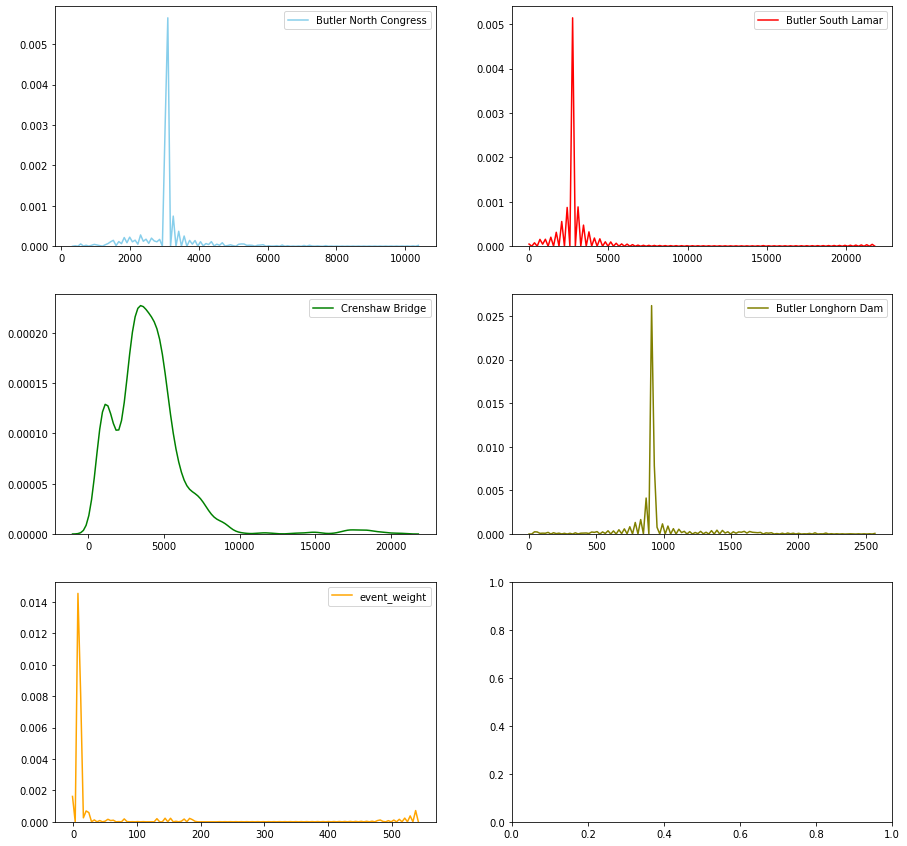

In [985]:
col_list = ['Butler North Congress','Butler South Lamar','Crenshaw Bridge','Butler Longhorn Dam', 'event_weight']
plot_distribution(data, col_list)

Most popular trails in order are : 
    1. crenshaw
    2. south
    3. north
    4. longhorn
    5. shoal

### Merging imputed data and events data :

In [995]:
data = pd.read_csv("full_data_imputed.csv")

events = pd.read_csv("events_df.csv")
data = data.rename(columns = {'Unnamed: 0' : 'Time'})
events['Time'] = pd.to_datetime(events['Time'])
data['Time'] = pd.to_datetime(data['Time'])

events = events.rename(columns = {'Butler Trail : Crenshaw Bridge - Urban Trail' : 'Crenshaw Bridge', 'Butler Trail: South Lamar - Urban Trail' : 'Butler South Lamar' , 'Butler Trail: North Congress - Urban Trail' : 'Butler North Congress', 'Butler Trail : Longhorn Dam - Urban Trail' : 'Butler Longhorn Dam'})

events.drop(['Shoal Creek Trail & 24th St- Urban Trail'], inplace=True, axis=1)
del events['DATE']

events['day'] = events['Time'].dt.day
events['month'] = events['Time'].dt.month
events['woy'] = events['Time'].dt.week

data = data.merge(events[['event_weight','Time']], left_on = ['Time'], right_on = ['Time'], how='left')

temp = events[events['Time'] < '2018-03-26']

data = data.append(temp)

In [429]:
data.to_csv("full_df.csv")

## FORECASTING WITH KALMAN FILTER

### Reading events data and imputed data 

In [1069]:
data = pd.read_csv("full_df.csv")
del data["Unnamed: 0"]

### Modeling the process model : Crenshaw bridge traffic is a function of TMAX, TMIN, event_weight and PRCP

In [1070]:
data.sort_values(['Time'], inplace=True)
temp_data = data.copy()
modeling_crenshaw = data.fillna(0)
regr_cb = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=200)
X = modeling_crenshaw[['TMAX', 'TMIN', 'event_weight', 'PRCP']]
regr_cb.fit(X, modeling_crenshaw['Crenshaw Bridge'])
print("R2 for process model", regr_cb.score(X, modeling_crenshaw['Crenshaw Bridge']))

R2 for process model 0.7793462587359631


In [1074]:
cb_kalman = data.copy()
cb_kalman.reset_index(inplace=True, drop=True)
cb_kalman['state_crenshaw'] = regr_cb.predict(cb_kalman[['TMAX', 'TMIN', 'event_weight', 'PRCP']])
cb_kalman['Index'] = cb_kalman.index

# Making the test set :

test_index = 1200
cb_kalman['Crenshaw Bridge'][test_index: ] = np.nan

In [1075]:
def calculate_kalman_gain(data, cb_kalman):
    cb_std = data['Crenshaw Bridge'].std()
    est_std = cb_kalman['state_crenshaw'].std()
    kg = (cb_std*cb_std)/((cb_std*cb_std) + (est_std*est_std))
    return kg

In [1076]:
kalman_gain = calculate_kalman_gain(data, cb_kalman)

In [1078]:
## Kalman filter approach : 

def kalman_filter(cb_kalman, kalman_gain, test_index):
    cb_kalman['estimated_traffic'] = np.nan
    idx = 0
    for i in cb_kalman.itertuples():
        if(i.Index == 0):
            cb_kalman.set_value(i.Index, 'estimated_traffic', cb_kalman['Crenshaw Bridge'].ix[0])
            idx = 0

        # since this is where the test set begins:
        elif(i.Index>=test_index):
            kalman_gain_test = 0.4
            cb_kalman.set_value(i.Index, 'estimated_traffic', kalman_gain_test * (cb_kalman.get_value(idx, 'estimated_traffic') + ((1 - kalman_gain_test) * cb_kalman.get_value(i.Index, 'state_crenshaw'))))

        else:
            cb_kalman.set_value(i.Index, 'estimated_traffic', kalman_gain * (cb_kalman.get_value(idx, 'Crenshaw Bridge') + ((1 - kalman_gain) * cb_kalman.get_value(i.Index, 'state_crenshaw'))))
            idx = i.Index
    return cb_kalman

In [1079]:
cb_kalman_results = kalman_filter(cb_kalman, kalman_gain, test_index)

Text(0.5, 1.0, 'Kalman Filter predictions for Crenshaw bridge')

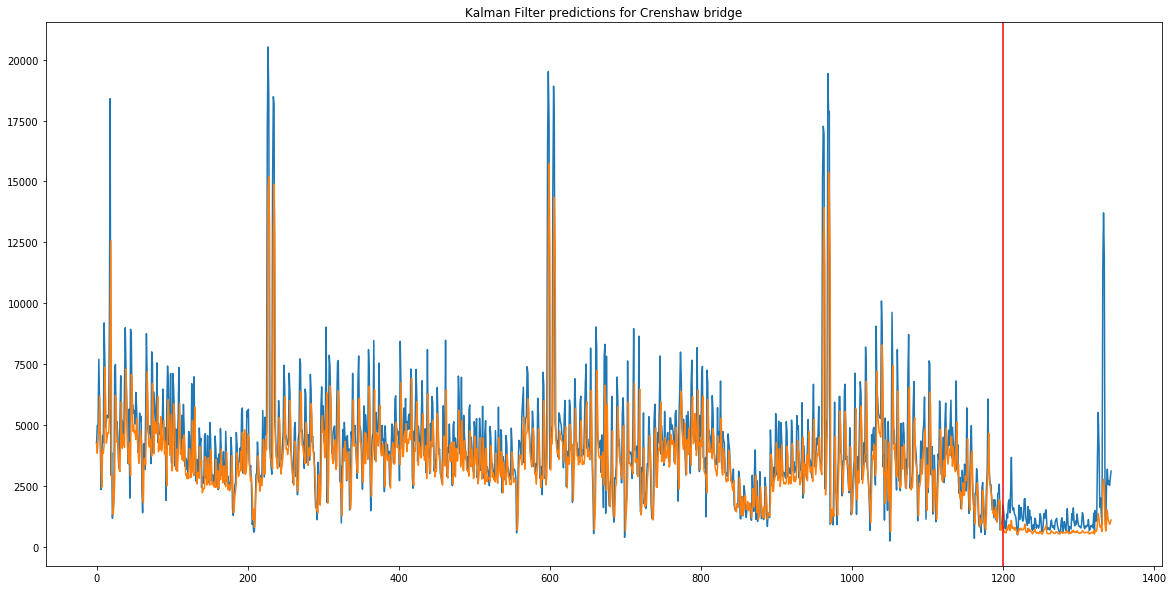

In [1082]:
plt.rcParams['figure.figsize']=[20,10]
plt.plot(data['Crenshaw Bridge'].values)
plt.plot(cb_kalman_results['estimated_traffic'])
plt.axvline(1200, color='red')
plt.title("Kalman Filter predictions for Crenshaw bridge")

In [1087]:
def kalman_model_scoring(data, cb_kalman_results):
    normalized_df=(data['Crenshaw Bridge']-data['Crenshaw Bridge'].mean())/(data['Crenshaw Bridge'].std())
    normalized_df_est=(cb_kalman['estimated_traffic']-cb_kalman['estimated_traffic'].mean())/(cb_kalman['estimated_traffic'].std())
    return mean_squared_error(normalized_df, normalized_df_est)

In [1088]:
print("Mean Sq Error for Kalman Filter Forecast", kalman_model_scoring(data, cb_kalman_results))

Mean Sq Error for Kalman Filter Forecast 0.5641854815227101


### SARIMA Model Forecast

In [1093]:
import pandas as pd
from sklearn import preprocessing
def preprocessing_data(df):
    columns = ['Butler Longhorn Dam','Butler North Congress','Butler South Lamar','Crenshaw Bridge','PRCP','TMAX','TMIN', 'event_weight']
    x = df[columns].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=columns)
    return df

In [1094]:
# Change these timestamps based on the test set timestamps for each trailhead

def select_data(df):
    train = df[(df.index >='2018-03-26') & (df.index <='2019-07-20')]
    test = df[df.index > '2019-07-20']
    return train, test

In [1095]:
def arima_model_uni(df, window, trailhead, exo_cols):
    # df : dataframe
    # window : window size of future predictions
    # trailhead : the trail to predict for
    # exo_cols : external variables
    
    train, test = select_data(df)
    train = preprocessing_data(train)
    test = preprocessing_data(test)
    sarima_model = pm.auto_arima(y=np.array(train[trailhead]).reshape(len(train),),
                          #  exogenous=np.array(train[exo_cols]).reshape(len(train), 4),
                             m=7,
                             seasonal=True,
                             information_criterion='aic',
                             trace=True, 
                             suppress_warnings=True, 
                             stepwise=True
                            )
    exo_test = test[exo_cols]
    predictions = sarima_model.predict(window, exo_test)
    return mean_squared_error(test[trailhead], predictions), predictions

In [1097]:
# Univariate case
days = [94]
mse_uni= []
predictions_df_uni = pd.DataFrame()
data= pd.read_csv("full_df.csv")
data['Time'] = pd.to_datetime(data['Time'])
data.set_index(['Time'], inplace=True)
data.sort_index(inplace=True)


del data['Unnamed: 0']

for window in days:
    exo_cols = ['TMAX','TMIN','PRCP', 'event_weight']
    trailhead = 'Butler South Lamar'
    mse, preds = arima_model_uni(data, window, trailhead, exo_cols)
    predictions_df_uni[str(window)] = preds
    mse_uni.append(mse)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=-1372.793, BIC=-1339.369, Fit time=1.392 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=-1103.762, BIC=-1095.406, Fit time=0.083 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=-1292.749, BIC=-1276.038, Fit time=0.451 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=-1294.872, BIC=-1278.160, Fit time=0.498 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 7); AIC=-1303.355, BIC=-1274.110, Fit time=1.211 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 7); AIC=-1373.142, BIC=-1335.540, Fit time=1.918 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 7); AIC=-1350.613, BIC=-1317.190, Fit time=1.881 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 7); AIC=-1378.100, BIC=-1336.320, Fit time=2.630 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 2, 7); AIC=-1380.234, BIC=-1342.632, Fit time=2.462 seconds
Fit ARIMA: order=(1

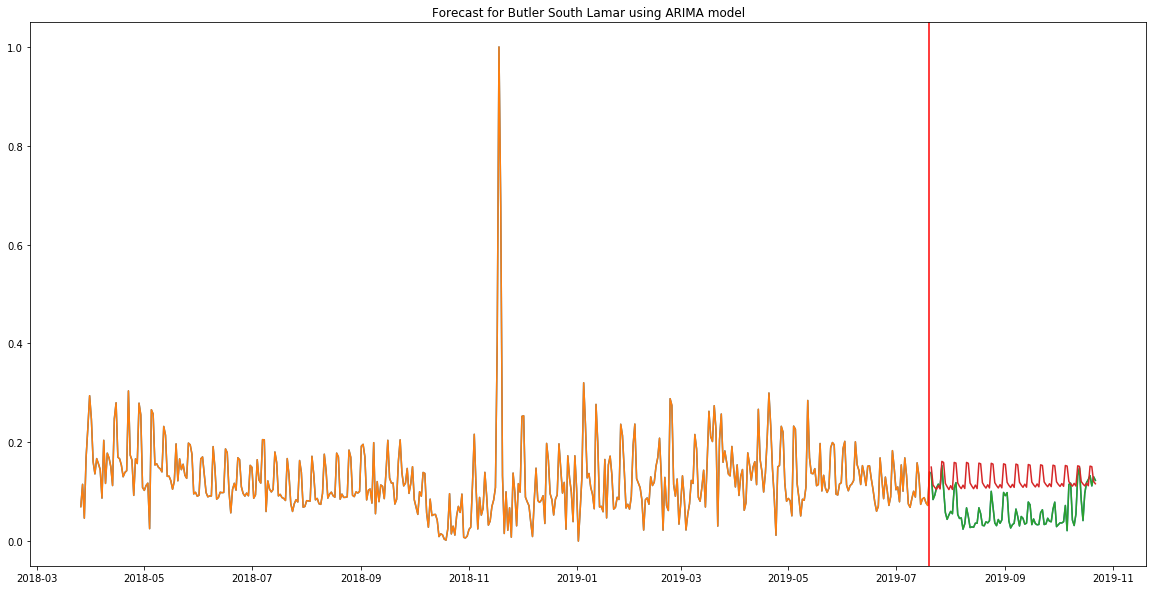

In [1099]:
train, test = select_data(data)
predictions_df_uni.set_index(test.index[-94:], inplace=True)

plt_data = preprocessing_data(data)

plt_data.set_index(data.index, inplace=True)

plt.plot(plt_data['Butler South Lamar'])
plt.plot(plt_data['Butler South Lamar'][:1250])
plt.plot(plt_data['Butler South Lamar'][1250:])
plt.axvline('2019-07-20', color='red')
plt.title('Forecast for Butler South Lamar using ARIMA model')
plt.plot(predictions_df_uni)

In [1104]:
mse_uni

[0.1027077810906694]

In [1101]:
def arima_model(df, window, trailhead, exo_cols):
    # df : dataframe
    # window : window size of future predictions
    # trailhead : the trail to predict for
    # exo_cols : external variables
    
    train, test = select_data(df)
    train = preprocessing_data(train)
    test = preprocessing_data(test)
    sarima_model = pm.auto_arima(y=np.array(train[trailhead]).reshape(len(train),),
                             exogenous=np.array(train[exo_cols]).reshape(len(train), 4),
                             m=7,
                             seasonal=True,
                             information_criterion='aic',
                             trace=True, 
                             suppress_warnings=True, 
                             stepwise=True
                            )
    exo_test = test[exo_cols]
    predictions = sarima_model.predict(window, exo_test)
    return mean_squared_error(test[trailhead], predictions), predictions

In [1102]:
# EXO variables
days = [94]
#days = [3, 7, 14, 30, 44, 60, 74, 88, 104, 118, 130, 144]
mse_exo = []
predictions_df_exo = pd.DataFrame()

for window in days:
    exo_cols = ['TMAX','TMIN','PRCP', 'event_weight']
    trailhead = 'Butler South Lamar'
    mse, preds = arima_model(data, window, trailhead, exo_cols)
    predictions_df_exo[str(window)] = preds
    mse_exo.append(mse)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=-1360.889, BIC=-1310.753, Fit time=1.626 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=-1103.792, BIC=-1078.725, Fit time=0.341 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=-1286.898, BIC=-1253.474, Fit time=1.074 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=-1289.708, BIC=-1256.285, Fit time=1.013 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 7); AIC=-1300.221, BIC=-1254.264, Fit time=1.876 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 7); AIC=-1361.295, BIC=-1306.981, Fit time=2.587 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 0, 7); AIC=-1349.574, BIC=-1299.439, Fit time=2.431 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 2, 7); AIC=-1372.083, BIC=-1313.592, Fit time=3.343 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 0, 2, 7); AIC=-1365.192, BIC=-1310.878, Fit time=3.192 seconds
Fit ARIMA: order=(3

In [1103]:
mse_exo

[0.10328087487194929]

In [ ]:
### Plotting

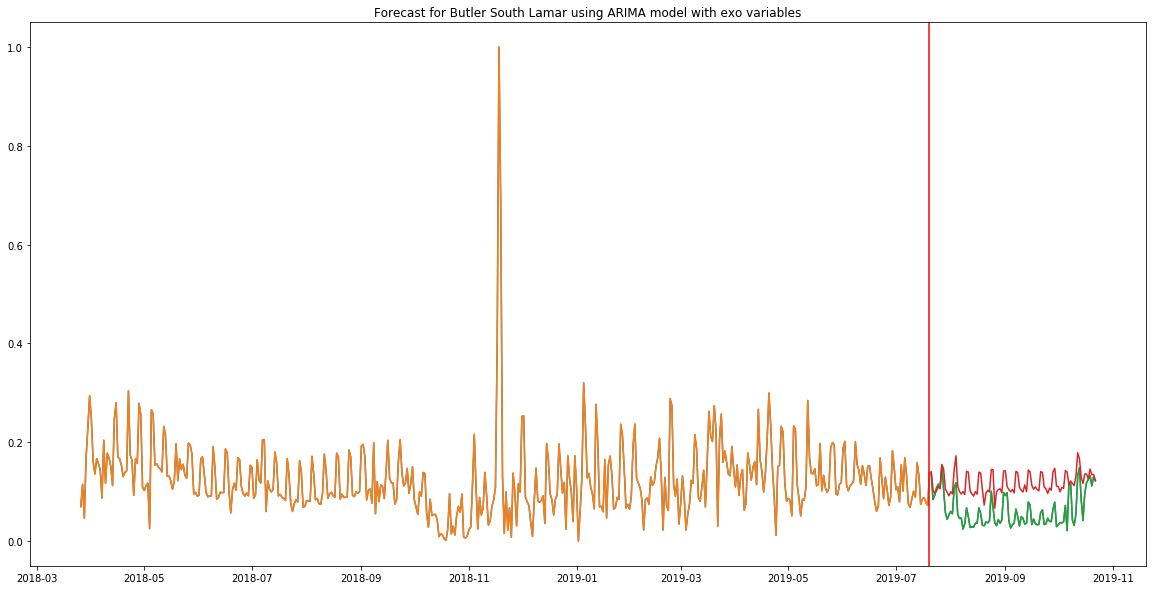

In [1105]:
data= pd.read_csv("full_df.csv")
data['Time'] = pd.to_datetime(data['Time'])
data.set_index(['Time'], inplace=True)
data.sort_index(inplace=True)


del data['Unnamed: 0']

train, test = select_data(data)
predictions_df_exo.set_index(test.index[-94:], inplace=True)

plt_data = preprocessing_data(data)

plt_data.set_index(data.index, inplace=True)

plt.plot(plt_data['Butler South Lamar'])
plt.plot(plt_data['Butler South Lamar'][:1250])
plt.plot(plt_data['Butler South Lamar'][1250:])
plt.axvline('2019-07-20', color='red')
plt.title('Forecast for Butler South Lamar using ARIMA model with exo variables')
plt.plot(predictions_df_exo)